In [42]:
### These are all libraries you will need throughout this exercise. 
### Be sure that this cell is compiled well.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

import cv2
from scipy import ndimage as ndi

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Welcome to the first graded exercise

You are asked to fill in the code in a couple of cells throughout the exercise. In the end of each cell where we ask you to fill in some code, you will notice a call to a function from the `save_student_results` module. This ensures that the body of your function is run with pre-generated data and your current results are saved to a file (which you will eventually submit to Moodle). The cells are independent of each other and you will receive points for each individual cell. 

Before you finish, please make sure to **upload two files to Moodle**:
* **graded_exercise_1.ipynb**
* **answers_SCIPER.npz (e.g. "answers_123456.npz")**

Good luck! :)

In [43]:
### scripts used for automated grading
import grading.save_student_results as save_student_results

In [44]:
### FILL IN YOUR SCIPER NUMBER
sciper_number = 350968  # e.g. 123456
save_student_results.initialize_res(locals())

### All exercises are Edge Detection problems:

* Part 1: Canny Edge Thresholding
* Part 2: Non-Maximum Suppression
* Part 3: Hysteresis Thresholding

Before you start, we highly recommend to look through all the cells you will implement to get a better understanding what to expect. Once you start, read carefully all the documentation we provide and the notations we use in a current exercise.

Use your time wisely, it is very challenging to finish all the tasks in a short time you have. 

### Good luck and show your best!

___________

# Part 1: Canny Edge Detection

Let us start with one of the simplest edge detection algorithms: Canny. We will proceed in steps and implement some key image processing functions that are required for applying Canny.

Cells to implement:
* `gausian_kernel_1d` - kernel of the 1D Gaussian distribution
* `gaussian_kernel_2d` - kernel of the 2D Gaussian distribution as the composition of two 1D
* `apply_conv_2d_with_stride_2` - modify the code for 2D Convolution adding 2x stride
* `thresholding` - threshold pixel values of the image to binary values

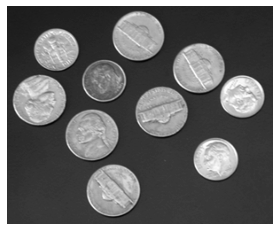

In [45]:
import helpers_canny

### Let us look at the "coins" picture:
img = cv2.imread('./presaved/coins.png', 0)
plt.axis('off')
plt.imshow(img, cmap='gray');

## 1.1: Image Smoothing. Gaussian 1D

The "blurring" (or "smoothing", or "low-pass filtering") is a routine operation in signal processing. One of the most popular filters used is the Gaussian smoothing. 

Implement a normalized centered 1D gaussian kernel function `k = gaussian_kernel_1d(size, sigma)`, 
where for each element $i$ the output kernel has the following value:

$$
k_i = A\cdot\exp{\Big(- \frac{i^2}{2\sigma^2}}\Big)
$$
where $A$ is a normalization factor chosen such that $\sum_i k_i = 1$ .

_Notes_: 
* `size` is always an **odd** number;
* $i \in \big[-\frac{size-1}{2}, \frac{size-1}{2}\big]$


In [46]:
def gaussian_kernel_1d(size, sigma):
    '''
        size: 1d scalar, the size of a gaussian filter. Always > 0. Always odd.
        sigma: 1d scalar, the standard deviation of a gaussian distribution. Always > 0
        
        return 1d np.array, 1d normalized gaussian kernel (gaussian filter)
    '''
    assert size > 0, "size must be > 0"
    assert size % 2 == 1, "size must be odd"
    assert sigma > 0, "sigma must be > 0"

    i = np.arange(-(size-1)/2, (size-1)/2+1)
    k = np.exp(-(i**2)/(2*sigma**2))
    return k / k.sum() # normalization is done for you

# Let us save the output of your function on some custom inputs 
save_student_results.save_gaussian_kernel_1d(locals())

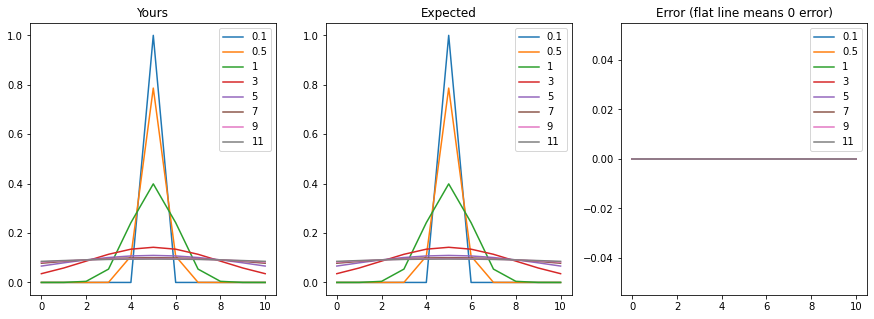

In [47]:
### We prepared a test with fixed size==11 and various sigmas for you:
helpers_canny.test_gauss_1d(gaussian_kernel_1d)

## 1.2: Image Smoothing. Gaussian 2D

The 2D Gaussian kernel can be seen as the composition of two 1D kernels, one along each axis. This property is called "separability" of the kernels.

Implement the function that returns a filter that corresponds to normalized centered 2D Gaussian, from the corresponding 1D kernel as input.

In [48]:
def gaussian_kernel_2d(kernel_1d):
    '''
        kernel_1d: np.array, 1d gaussian kernel
        
        return 2d np.array, 2d normalized gaussian kernel (gaussian filter)
    '''
    ### YOUR CODE HERE
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d / kernel_2d.sum() # normalization is done for you

# Let us save the output of your function on some custom inputs 
save_student_results.save_gaussian_kernel_2d(locals())

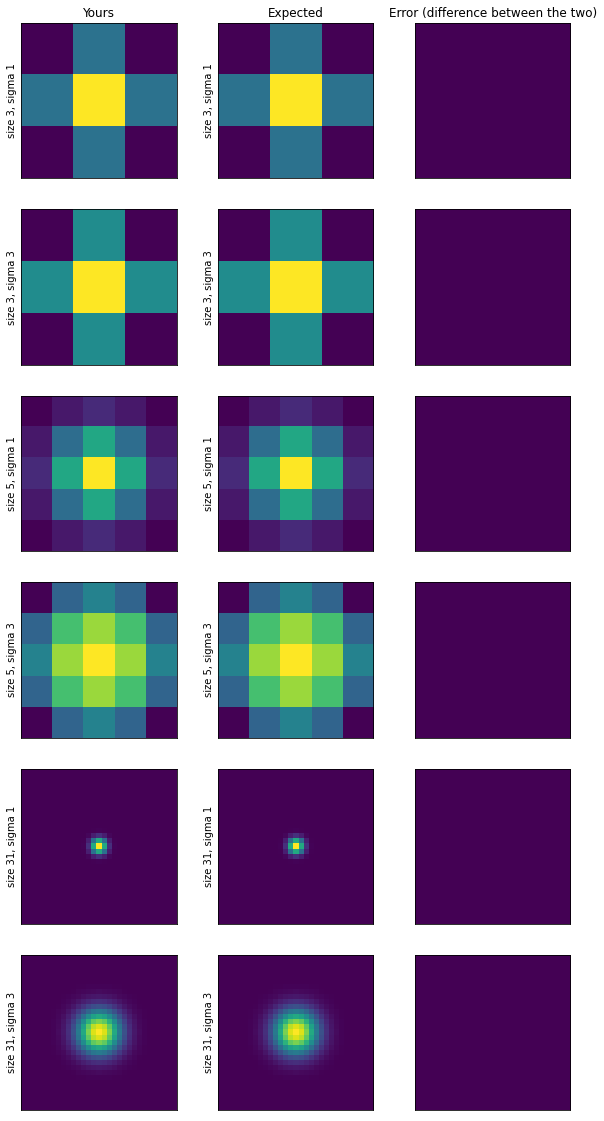

In [49]:
### We prepared a little test for you:
helpers_canny.test_gauss_2d(gaussian_kernel_2d)

## 1.3: Strided Convolution

Performing **strided** convolutions is a very usual scenario in real-world CV problems, when the resolution of an image is **too** high. A very high resolution might not just increase the computational burden, but also simply not bring any valuable information. For example, imagine scanning QR-codes from 8k Ultra HD photo of it - there would be too many pixels to store a simple information. 

One of the ways to deal with such images efficiently is to use strided convolutions ($stride > 1$) instead of standard convolutions ($stride = 1$). 

"Stride" implies that we convolve the image with the kernel not at all possible locations, but use steps of length $stride$ from one location to another.

You can get a better understanding of what strided convolution is from the following animations:


**No padding, stride 1**
![Alt Text](./presaved/no_padding_no_strides.gif)

**No padding, stride 2**
![Alt Text](./presaved/no_padding_strides.gif) 

Using the template for `apply_conv_2d` from the exercise session, implement a function `apply_conv_2d_with_stride_2(img, kernel)` that does convolution with a stride of $\mathbf{2}$. 

This function takes a gray-scale image `img` and a 2D convolution filter $filter$ as inputs, and returns the filtered result. The filter can be a 2d gaussian kernel, for example.

_Note_: the size of the output filtered image must be twice smaller along each axis than the input image. We assume the input image has even dimensions along both axis (ex. (512,512) is allowed, not (127,90)).

In [50]:
def apply_conv_2d_with_stride_2(img, kernel):
    '''
        img : 2d np.array, 2D gray-scale image of the size H x W. H and W are always even.
        kernel: 2d np.array, squared 2D convolution filter of size (2N+1) x (2N+1).
        
        return 2d np.array, a result of convolution img with the kernel with stride 2
    '''    
    # the following code is adapted from the exercise session
    if not np.issubdtype(img.dtype,float):
        img = np.float64(img)
    
    if not np.issubdtype(kernel.dtype,float):
        kernel = np.float64(kernel)
    
    N = (len(kernel)-1) // 2
    
    # Shape of the input image
    W, H = img.shape
    img = np.pad(img, ((N,N),(N,N)), mode='constant') # default value for padding is 0 in np.pad
        
    #################################    
    #    ### solution for convolution with stride 1 (from exercise session)
    #     R = np.zeros((W,H), dtype = np.float64) 
    #     W_R, H_R = R.shape
    #     for x in range(W_R): # iterating through rows of the output image in the direction ↓
    #         for y in range(H_R): # iterating through columns of the output image in the direction →
    #             # compute the value for R[x, y] 
    #             # x is the row index
    #             # y is the column index  
    #             for i in range(-N,N+1):
    #                 for j in range(-N,N+1):  
    #                     R[x,y] += I[x+N-i, y+N-j]*F[i+N,j+N]
    #################################

    ### for convolution with stride 2 
    R = np.zeros((W//2,H//2), dtype = np.float64)
    W_R, H_R = R.shape
    for x in range(0, W_R): # iterating through rows of the output image in the direction ↓
        for y in range(0, H_R): # iterating through columns of the output image in the direction →
            # compute the value for R[x, y]
            # x is the row index
            # y is the column index
            for i in range(-N,N+1):
                for j in range(-N,N+1):
                    R[x,y] += img[2*x+N-i, 2*y+N-j]*kernel[i+N,j+N]
    
    return R

# Let us save the output of your function on some custom inputs 
save_student_results.save_apply_conv_2d_with_stride_2(locals())

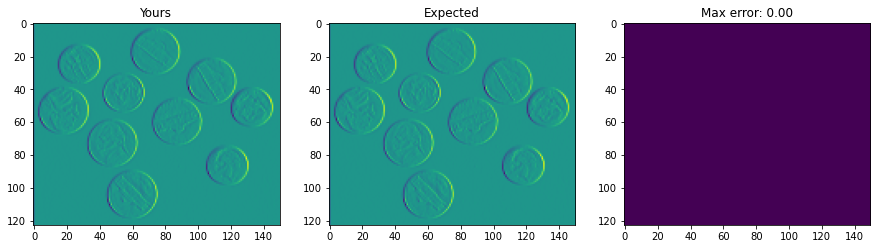

In [51]:
### We prepared a little test for you.
### We convolve original "coins.png" having shape of (246, 300) with stride 2
### and get a picture in the middle with the size (123, 150):
helpers_canny.test_strided_coins(apply_conv_2d_with_stride_2)

We can apply the gradient filtering from the previous cell along both $x$ and $y$ axes to obtain the gradient vector. Given the vector, one can compute its magnitude $M$: 

$$
\begin{align}
M = \sqrt{\frac{\partial I}{\partial x}^2 + \frac{\partial I}{\partial y}^2}
\end{align}
$$

We precomputed it for you, it looks as follows:

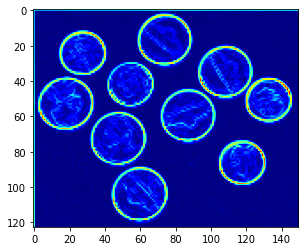

In [52]:
grad_magnitude = np.load('./presaved/grad_magnitude.npy')
plt.imshow(grad_magnitude, cmap='jet');

## 1.4 Binary Thresholding

To finish the Canny pipeline, one needs to threshold the gradient image values given a threshold.

Implement a function that takes a 1-channel image (magnitude of the gradient in our case) and a threshold and returns a binary image with $0$ if pixel value is less than threshold, and $255$ where it is greater.

In [53]:
def thresholding(img, threshold):
    '''
        img : 2d np.array, 2D gray-scale image of the size H x W. Type of pixel values: uint8
        threshold: float, a value from 0 to 255.
        return 2d np.array, a binarized image of the size H x W, with 0 and 255 values only.
    '''    
    img_binarized = img.copy()
    img_binarized[img_binarized < threshold] = 0
    img_binarized[img_binarized >= threshold] = 255
    return img_binarized

# Let us save the output of your function on some custom inputs 
save_student_results.save_thresholding(locals())

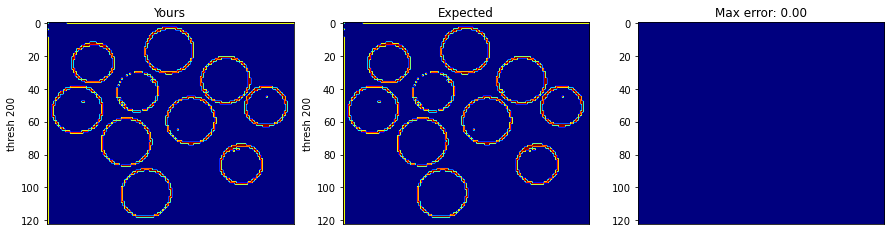

In [54]:
### You can use "grad_magnitude" array (see above) for your own tests

### Here is a test that we prepared for you where we apply only the threshold of 200:
helpers_canny.test_thresholding(thresholding)

Overall, applying Canny to an image looks as follows:

![Alt Text](./presaved/canny.png)

### Canny is done!

___________

# Part 2: Non-Maxima Suppression

Let us continue with another edge detection algorithms: Non-Maxima Suppression. 

This exercise concerns implementing a function which finds the **local maxima of image gradient**. 
As you have seen in previous lectures, gradient magnitude is a commonly used image feature. 
It is natural for finding image edges, however if we wish to have a binary edge/not-an-edge decision, it is unclear which value of threshold to apply.

One solution is to keep only the locations which are maximum in some local neighborhood. A naive implementation (considering for example a $3 \times 3$ neighborhood) would have discontinuities, because in each neighborhood at most 1 pixel would be on. To combat this issue, we will apply a more advanced technique, where we use information about gradient orientation to run the comparison only perpendicular to the gradient, allowing for continuous detection along the gradient.

<img src="./presaved/nms_overview.png" width=600 height=30 />


_Note_: In this figure (taken from lecture slides), `p` and `r` appear to have integer coordinates along the vertical axis. In this exercise this is not generally the case, with both coordinates being possibly fractional. We believe the figure was created in that way since it was easier for the artist.

Cells to implement:
* `gaussian_blur` - blur with Gaussian filter using `opencv`
* `compute_grad` - compute `dx` and `dy` image gradients using `opencv`
* `grad_direction` - compute the direction of the gradient (angle in polar coordinates)
* `bilinear_interpolation` - compute the value of the gradient magnitude given a position and neighboring pixels
* `find_p_r_coordinates` - find the coordinates of the point in front (`p`) and the point behind (`r`) of the position
* `is_max` - find a maximum of three scalar gradient value at `p`, `q` and `r` points

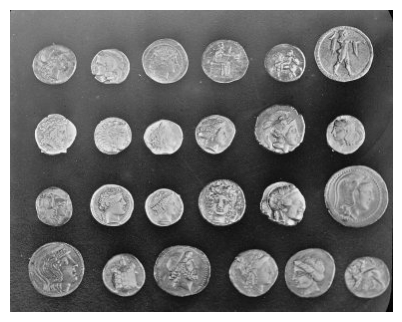

In [92]:
import helpers_nms

# ### Let us look at the "coins" picture:
from skimage.data import coins as get_coins_image
img = get_coins_image().astype(np.float32) / 255 # convert to [0, 1] range
fig, ax = plt.subplots(dpi=100)
ax.imshow(img, cmap='gray')
ax.set_axis_off()

The cells below contain implementation of the procedure in question, step by step. Your goal is to fill them in. We suggest that you scroll down to the section "the main function" to see how they are used together - this should help you understand the purpose of individual subroutines. Don't be surprised if some of the subtasks are rather trivial (often solveable by a single call to an external library) - `bilinear_interpolation` might be more laborious and involves the bulk of work.

After each subtask we present an example function call with expected results, to help you check the correctness of your results and make sure you're following the same conventions (regarding coordinate systems, for example). Note that passing those minitests doesn't guarantee your solution is correct on other inputs.

## 2.1 Gaussian Blurring

Use Gaussian blur to smooth the image, with a kernel of size `(3, 3)` and sigma along the X and Y axis equal to `1`. It should be sufficient to correctly use a single `opencv` function.

In [93]:
def gaussian_blur(img):
    '''
        img: 2d np.array, a 2-dimensional input image
        
        return 2d np.array, an array representing the image after applying Gaussian blurring
    '''
    blurred = cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=1, sigmaY=1)
    return blurred

# Let us save the output of your function on some custom inputs 
save_student_results.save_gaussian_blur(locals())

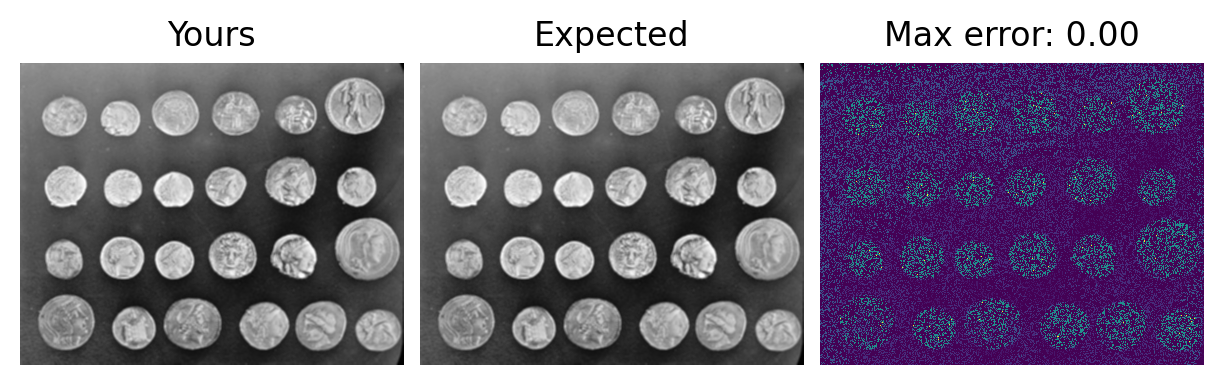

In [94]:
### here is a test function for you:
helpers_nms.test_blur(gaussian_blur)

## 2.2 Sobel Operator

Use the Sobel operator (again, opencv implementation is suggested) to compute the derivative of an input image along X and Y dimensions, using a kernel of size $3$. Return the gradients as a tuple of two numpy arrays.

In [95]:
def compute_grad(img):
    '''
        img: 2d np.array, a 2-dimensional input image
    
        return tuple, gradient magnitudes along the x and y axes, 
                                                a tuple of equally shaped numpy arrays
    '''
    dx = cv2.Sobel(img, ddepth=-1, dx=1, dy=0, ksize=3)
    dy = cv2.Sobel(img, ddepth=-1, dx=0, dy=1, ksize=3)
    return dx, dy

# Let us save the output of your function on some custom inputs 
save_student_results.save_compute_grad(locals())

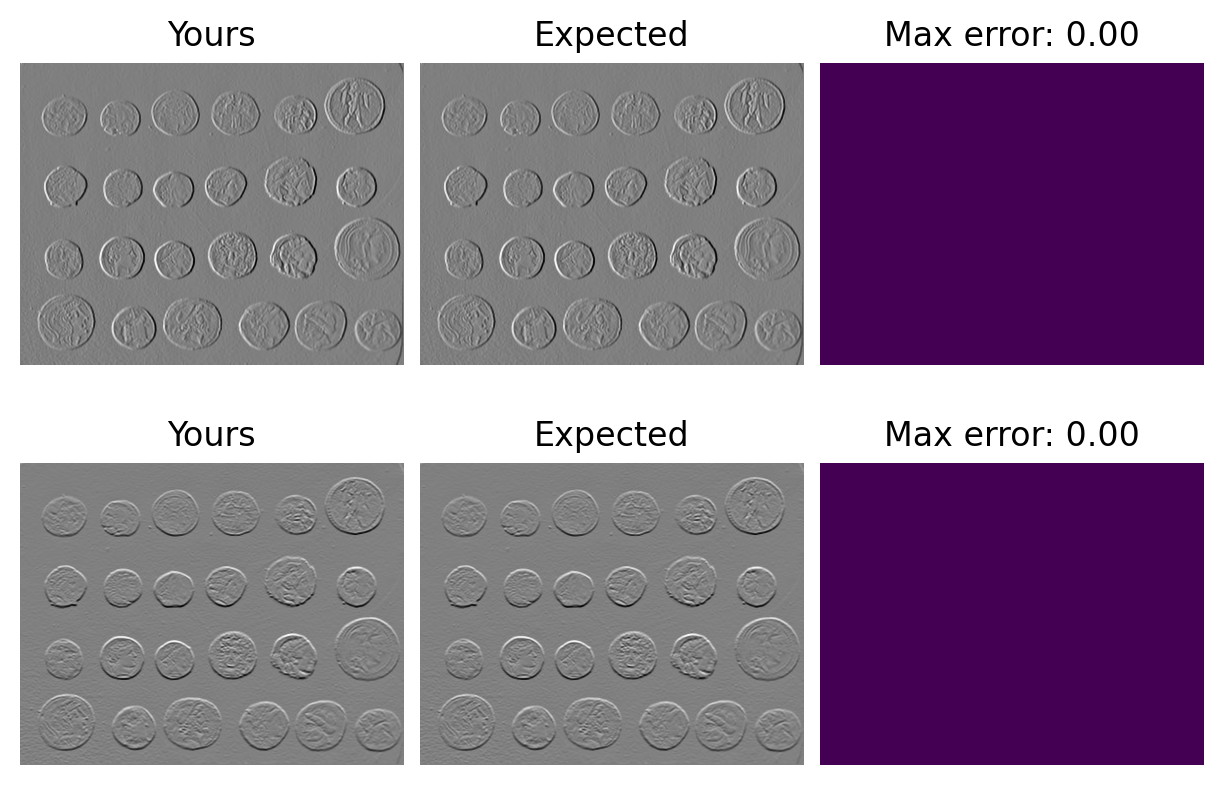

In [96]:
### here is a test function for you:
helpers_nms.test_grad(compute_grad)

## 2.3 Gradient Direction
Compute the gradient direction, in radians. Keep in mind to correctly identify the signs across the 4 quadrants of the coordinate system.

In [97]:
def grad_direction(grad_x, grad_y):
    '''
        grad_x: 2d np.array, a 2-dimensional gradient magnitude along the x axis
        grad_y: 2d np.array, a 2-dimensional gradient magnitude along the y axis
    
        return 2d np.array, a single array of shape equal to inputs, 
                    at each index containing the angle of the 
                    corresponding gradient vector [dx, dy], in radians
    '''
    grad_dir = np.arctan2(grad_y, grad_x)
    return grad_dir

# Let us save the output of your function on some custom inputs 
save_student_results.save_grad_direction(locals())

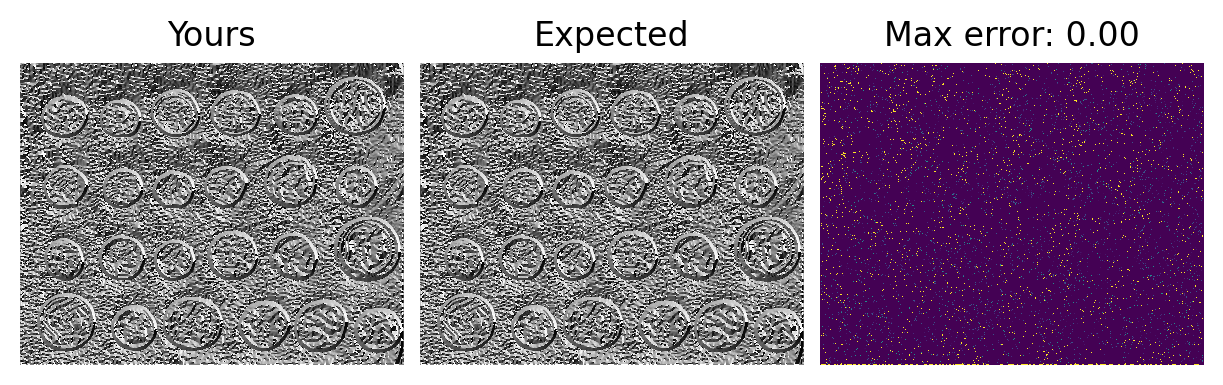

In [98]:
## here is a test function for you:
helpers_nms.test_direction(grad_direction)

## 2.4 Bilinear Interpolation

Digital images are defined on a discrete grid of pixels - this means that the color at non-integer coordinates is not defined. In situations when this information is necessary, one therefore needs to _interpolate_ it from neighboring integer-indexed pixels. 
The simplest approach is to just round the real-valued coordinates $(x, y) \in \mathbb{R}^2$ to the nearest $(i, j) \in \mathbb{N}^2$. In this exercise, we're considering a more complicated solution: bilinear interpolation. 1-dimensional linear interpolation is defined as
$\mathrm{lerp}(a, b, x) = (1 - \alpha) \cdot a + \alpha \cdot b$, where $a, b$ are the values at the nearest integer-indexed locations and $\alpha \in (0, 1)$ measures how far $x$ is from the coordinate corresponding to $a$. Bilinear interpolation is an extension to 2 dimensions, where we consider the 4 nearest neighbors of $(x, y)$ and we first interpolate along one axis, obtaining two numbers, and then interpolate those along the other axis.

_Note_: you don't have to cover the case of the nearest neighbor coordinates being out of bounds of the input image. Because in `non_maxima_suppression` we only consider $x \in [1, height-1]$ and $y \in [1, width-1]$, these edge cases will not happen.<br>
_Note_: it may be easier to implement bilinear interpolation by first defining _linear_ interpolation as a subroutine, but it is also possible to directly derive the weights on all 4 neighbors. Both solutions are correct. <br>
_Hint_: if you pass integer coordinates to your function, that is $(x, y) = (i, j)$, the result should be equal to just indexing the input image. This means you can easily implement some additional correctness tests below (not required).

In [99]:
from math import floor, ceil

### optional helper
def linear_interpolation(a, b, alpha):
    return (1 - alpha) * a + alpha * b


def bilinear_interpolation(source, x, y):
    '''
        source: 2d np.array, array of pixel intensities
        x: float, a real-valued coordinate into the 1st dimension of `source`
        y: float, a real-valued coordinate into the 2nd dimension of `source`
    
        return float, interpolated intensity of `source` at location (x, y)
    '''
    a_x, a_y = floor(x), floor(y)
    b_x, b_y = ceil(x), ceil(y)
    alpha_x = x - a_x
    alpha_a = y - a_y
    val = (1-alpha_x)*(1-alpha_a)*source[a_x, a_y] + \
          (1-alpha_x)*alpha_a*source[a_x, b_y] + \
          alpha_x*(1-alpha_a)*source[b_x, a_y] + \
          alpha_x*alpha_a*source[b_x, b_y]
    
    if val > 255:
       val = 255

    if int(x) == x and int(y) == y:
        assert val == source[int(x), int(y)]

    return val

# Let us save the output of your function on some custom inputs 
save_student_results.save_bilinear_interpolation(locals())

In [100]:
### here is a test function for you:
def test_bilinear_interpolation(bilinear_interpolation):
    intensities = np.array([
        [0.1, 0.5, 0.3],
        [0.3, 0.6, 0.6],
        [0.7, 0.1, 0.3],
    ])
    
    x, y = 1.5, 0.5 # Note: x stands for 0-axis, y - 1-axis
    
    expected = 0.425
    interp = bilinear_interpolation(intensities, x, y)
    error = abs(interp - expected)
    
    print('Error = {:.2f}'.format(error))

test_bilinear_interpolation(bilinear_interpolation)

Error = 0.00


## 2.5 Coordinates of $p$ and $r$ points
Use trigonometry to find the x and y coordinates of the points `p` and `r` "in front" and "behind" the query `q = (i, j)`. More specifically, given arrays containing the magnitude and direction of image gradients as well as coordinates `(i, j)` of the point `q`, you need to use trigonometry to find out the coordinates of `p = q + gradient_direction_at(q)` and `r = q - gradient_direction_at(q)`, where `gradient_direction_at` has a length of 1. 

In [101]:
def find_p_r_coordinates(grad_dir, i, j):
    '''
        grad_dir: 2d np.array, the array of gradient directions, in radians
        i: an integer-valued coordinate into the 1st dimension of the image
        j: an integer-valued coordinate into the 2nd dimension of the image
    
    return 
        p_x: the x-coordinate of p
        p_y: the y-coordinate of p
        r_x: the x-coordinate of r
        r_y: the y-coordinate of r
    '''
    grad_dir_angle = grad_dir[i, j]
    p_x = i + np.cos(grad_dir_angle)
    p_y = j + np.sin(grad_dir_angle)
    r_x = i - np.cos(grad_dir_angle)
    r_y = j - np.sin(grad_dir_angle)
    return p_x, p_y, r_x, r_y

# Let us save the output of your function on some custom inputs 
save_student_results.save_find_p_r_coordinates(locals())

In [102]:
### here is a test function for you:
def test_find_p_r_coordinates(find_p_r_coordinates):
    intensities = np.array([
        [0.1, 0.5, 0.3],
        [0.3, 0.6, 0.6],
        [0.7, 0.1, 0.3],
    ])
    
    i, j = 1, 1
    
    ep_x, ep_y, er_x, er_y = (1.8253356149096782, 1.5646424733950353, 0.17466438509032167, 0.43535752660496463)
    p_x, p_y, r_x, r_y = find_p_r_coordinates(intensities, i, j)
    
    
    print(f'Error on p_x = {abs(ep_x-p_x):.2f}, '\
          f'error on p_y = {abs(ep_y-p_y):.2f}, '\
          f'error on r_x = {abs(er_x-r_x):.2f}, '\
          f'error on r_y = {abs(er_y-r_y):.2f}')

test_find_p_r_coordinates(find_p_r_coordinates)


Error on p_x = 0.00, error on p_y = 0.00, error on r_x = 0.00, error on r_y = 0.00


The following function combines the previous two methods you implemented and is called by the final function at the end. You do not need to modify it, it is just here to show you how the methods you implement are used.

In [103]:
def interpolate_grad_value(grad_mag, p_x, p_y, r_x, r_y):
    p_value = bilinear_interpolation(grad_mag, p_x, p_y)
    r_value = bilinear_interpolation(grad_mag, r_x, r_y)
    return p_value, r_value

## 2.6 Is Max?
Implement the check to establish if `p` is a local gradient maximum, comparing to the values at `q` and `r`. If that is the case, return the gradient magnitude; otherwise return 0. Please use _strict inequalities_ (`>` instead of `>=` and `<` instead of `<=`).

_Note_: there are no automated checks for this portion of your code, its correctness is checked along with the main function further below.

In [104]:
def is_max(grad_p, grad_q, grad_r):
    '''
        grad_p: float, gradient value at location "behind" q, along the gradient direction
        grad_q: float, gradient value at location q 
        grad_r: float, gradient value at location "in front" of q, along the gradient direction
    
        return grad_p if p is a local maximum, 0 otherwise
    '''
    max_grad = 0
    if grad_p > grad_q and grad_p > grad_r:
        max_grad = grad_p
  
    return max_grad

# Let us save the output of your function on some custom inputs 
save_student_results.save_is_max(locals())

In [105]:
### here are some tests for you:
print(f'Error1: {np.abs(is_max(1, 2, 3) - 0):.2f}')
print(f'Error2: {np.abs(is_max(3, 2, 1) - 3):.2f}')
print(f'Error3: {np.abs(is_max(3, 1, 2) - 3):.2f}')

Error1: 0.00
Error2: 0.00
Error3: 0.00


## NMS main function
You don't need (and shouldn't!) modify anything there, if the preceding code is correct, this will work as well :)

In [106]:
def non_maxima_suppression(img, thresh):
    '''
    Inputs:
        img: the input image, a numpy array
        thresh: threshold to apply on the image, float
    Outputs:
        An array with image gradient intensities in their local maxima locations and 0 elsewhere.
    '''
    blurred_img = gaussian_blur(img)
    grad_x, grad_y = compute_grad(blurred_img)
    grad_dir = grad_direction(grad_x, grad_y)
    grad_mag = np.sqrt(grad_x ** 2 + grad_y ** 2)
    grad_mag = np.where(grad_mag > thresh, grad_mag, 0)
    
    w, h = img.shape
    result = np.zeros((w, h), dtype=np.int32)
    for i in range(1, w - 1):
        for j in range(1, h - 1):
            p_x,p_y,r_x,r_y=find_p_r_coordinates(grad_dir, i, j)
            grad_p, grad_r = interpolate_grad_value(grad_mag, p_x, p_y, r_x, r_y)
            result[i, j] = is_max(grad_mag[i, j], grad_p, grad_r)
    return result

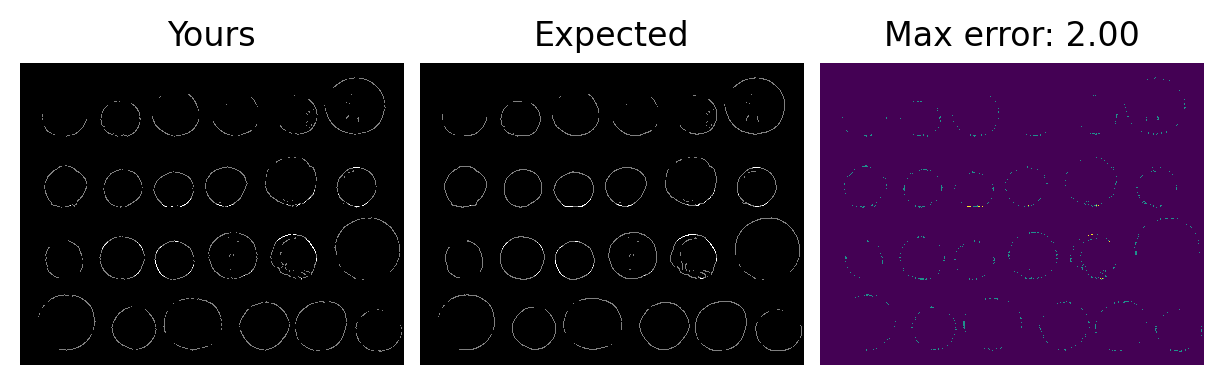

In [107]:
def test_nms():
    nms = non_maxima_suppression(img, 0.5)
    expected = np.load('./presaved/nms.npy')
    error = np.abs(nms - expected)
    
    fig, axes = plt.subplots(1, 3, constrained_layout=True, dpi=200)
    
    axes[0].imshow(nms, cmap='gray')
    axes[1].imshow(expected, cmap='gray')
    axes[2].imshow(error)
    
    axes[0].set_title('Yours')
    axes[1].set_title('Expected')
    axes[2].set_title('Max error: {:.2f}'.format(error.max()))
    
    for ax in axes:
        ax.set_axis_off()

test_nms()

### Non-Maxima Suppression is done!

______

# Part 3: Hysteresis thresholding

Let us turn to next algorithm: **hysteresis thresholding** to the gradient of the image. This technique is mostly used to refine edge detection in a given image.

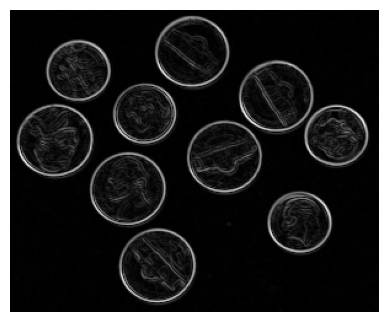

In [71]:
import helpers_hyst

# Let us upload presaved gradients of the "coins.png" picture:
img = cv2.imread('./presaved/coins_gradient.png', 0)
fig, ax = plt.subplots(dpi=100)
ax.imshow(img, cmap='gray')
ax.set_axis_off()

We will implement two versions of Hysteresis thresholding, a naive and an efficient. 

Cells to implement:
* `label_pixels` - assign a class label (0,1 or 2) to each pixel
* `update` - update a pixel value if a conditions is satisfied
* `fast_hysteresis_thresholding` - fill in necessary lines in a fast implementation
* `time_counter` - the function that computes the mean and std of the evaluation for a given function 

This first part will ask you to complete a straightforward but relatively slow version of the hysteresis thresholding. 

## 3.1 Label Pixels
To simplify things, first we want to construct a function that maps the values of the image into three different categories: 0 if the value is **below the low threshold**, 1 if the value is **between the low and high thresholds**, and 2 if the value is **above the high threshold**. Complete the function `label_pixels`.

In [72]:
def label_pixels(img, low=60, high=180):
    '''
    This function takes an input image and two thresold values, and returns a labelled mask according to the image intensity values.
    The pixel values less than the lower threshold are assigned a label 0, whereas those above the higher threshold are assigned a label 2.
    Otherwise, the pixels in between the lower and higher threshold are assigned label 1. 
    
    img: 2d np.array, an input image 
    low: integer, represents the low threshold value.  
    high: integer, represents the high threshold value. 
    
    return labeled_img: a labelled image
        
    '''
    
    # Categorize the values of the image into three categories as described: 
    # Assign the pixel at (x,y) to 0 if I(x,y) < low
    # Assign the pixel at (x,y) to 1 if low <= I(x,y) < high
    # Assign the pixel at (x,y) to 2 if I(x,y) >= high
    
    labeled_img = img.copy()
    labeled_img[labeled_img < low] = 0
    labeled_img[(low <= labeled_img) & (labeled_img < high)] = 1
    labeled_img[labeled_img >= high] = 2

    return labeled_img

# Let us save the output of your function on some custom inputs 
save_student_results.save_label_pixels(locals())

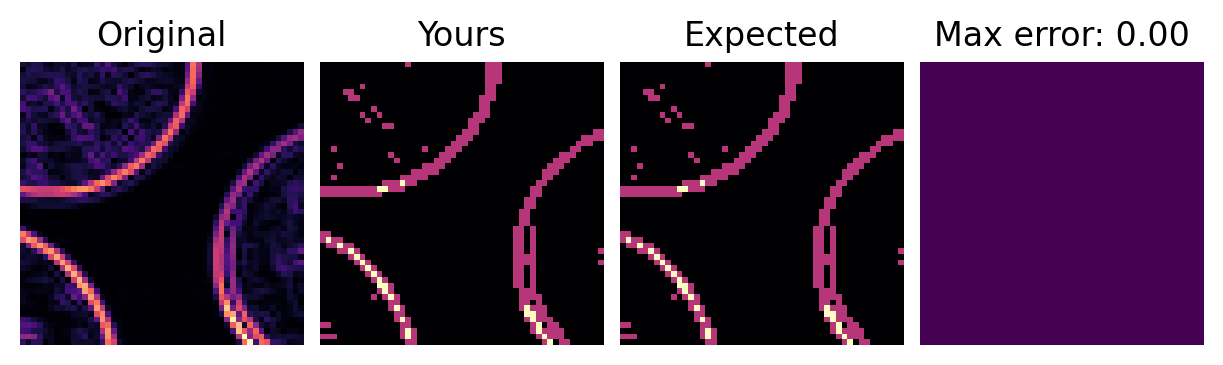

In [73]:
### here is a test for you:
helpers_hyst.test_label_pixels(label_pixels)

## 3.2 Update

The dual thresholding function above applied to a gradient magnitude image returns 3 kinds of values for each pixel:
- 0 pixels are **not** edges since the gradient magnitude is too low.
- 1 pixels might be edges, since the gradient magnitude is high but not so much. We call them weak edges.
- 2 pixels are edges, since the gradient magnitude is very high. We call them strong edges.

A naive implementation of hysteresis thresholding consists in turning weak edges into strong ones when one of their 4 neighbors is a strong edge. This updating operation is repeated until convergence. Eventually, after convergence, all pixels labelled as strong edges correspond to connected components of initially labelled (weak + strong) edges that had at least one strong edge before applying the update function.

Now, we ask you to complete the `update` function, which is called at each iteration on the `hysteresis_thresholding` function until convergence. It updates the state of a pixel `(i,j)`, and turns it into a strong edge if it is a weak one, and has a strong neighbor.

_Hint_: You need to pay attention to the border pixels. If `(i,j)` is the position of a border pixel, then you need to check only for the valid neighbouring pixels. 

In [74]:
def update(img, i, j):
    '''
    NOTE: here i refers to rows, j - to columns
    
    This function updates the image at the pixel value (i,j) if it is an edge that is connected to a strongly connected edge.
    If the pixel (i,j) does not belong to an edge, then this function does not change anything. 
    Otherwise, this function investigates the four neighbouring pixels to the pixel representing the weak edge, and checks 
    if any of these four pixels is a strongly connected edge. 
    
    img: 2d np.array, input image that may be updated
    i: int - row coordinate
    j: int - col coordinate
            coordinates of the pixel that the function considers to update
    
    return img: 2d np.array, an updated version of the original image
    '''
    h = img.shape[0]
    w = img.shape[1]
    # Update the pixel value indicated at the position (i,j) if it is a weak edge connected to a strongly connected edge
    # Otherwise, do not change anything. Check how the function slow_hysteresis_thresholding below works for a better understanding
    if (img[i,j] == 1) and (img[i-1:i+2, j].max(initial=1) == 2 or img[i, j-1:j+2].max(initial=1) == 2):
        img[i, j] = 2

    return img

# Let us save the output of your function on some custom inputs 
save_student_results.save_update(locals())

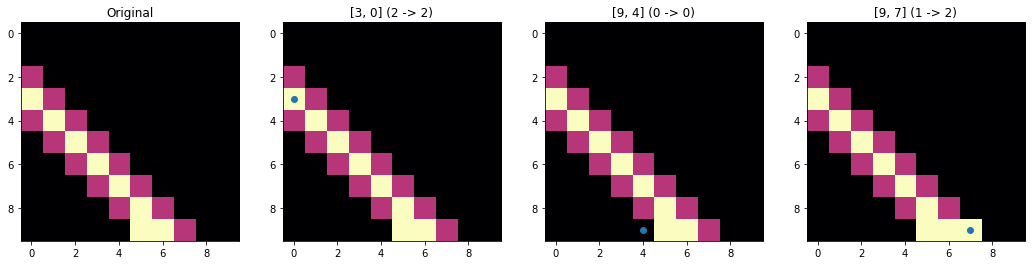

In [75]:
### here is a test for you:
helpers_hyst.test_update(update)

In [76]:
def slow_hysteresis_thresholding(im):
    '''
    This function applies hysteresis thresholding to the input image by iterating over all pixels and performing one step of the 
    algorithm until convergence. Each step of the algorithm can be described as follows: 
    1. Iterate over all the pixel values.
    2. For each pixel value, perform an update if it is a weak edge connected to a strongly connected edge. 
    3. If the new image is different from the original image, we repeat the algorithm again. 
    4. Otherwise, the algorithm converges and the function terminates.
    
    Parameters:
        image: input image for which hysteresis thresholding will be applied.
    
    Returns: 
        labeled_image: output image with detected edges.
        
    '''
    image = im.copy()
    h = image.shape[0]
    w = image.shape[1]
    old_s = np.inf
    s = sum(sum(image))
    while (old_s!=s):
        for i in range(h):
            for j in range(w):
                image = update(image, i, j)
        
        #Checks at each iteration if the algorithm has converged
        old_s = s
        s = sum(sum(image))
        
    image[image<2] = 0
    image = np.array(image, dtype=bool)
    return image

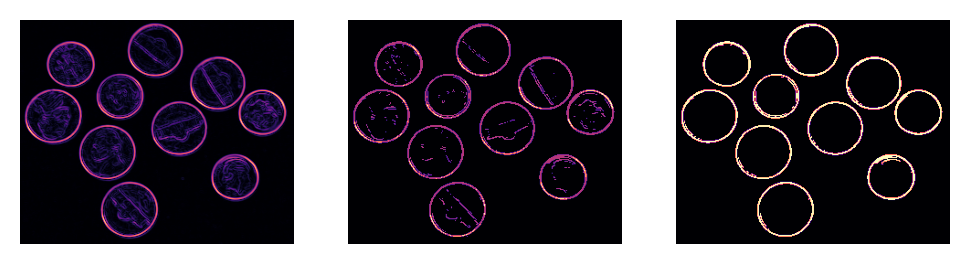

In [77]:
labeled_img = label_pixels(img)
thresholded = slow_hysteresis_thresholding(labeled_img)

fig, ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(img, cmap='magma')
ax[1].imshow(labeled_img, cmap='magma')
ax[2].imshow(thresholded, cmap='magma')
for axis in ax: axis.set_axis_off()

## 3.3 Efficient implementation
Complete the fast implementation of the Hysteresis thresholding. To this end, the use of the `label` function of the `ndimage` library could be handy...

In [78]:
def fast_hysteresis_thresholding(img, low=60, high=180):
    '''
    This function applies fast hystersis thresholding as follows: It takes an input image and two thresold values.
    It first finds pixel values less than the lower threshold value and identifies them as "no edges",
    the pixel values above than the higher threshold value and identifies them as "strong edges",
    and the pixel values between the low and high threshold values and identifies them as "weak edges".
    
    These weak edges are further inspected if they are connected to strong edges to consider them as "strong edges" 
    or not. 
    
    img: 2d np.array, an input image 
    low: int, represents the low threshold value.  
    high: int, represents the high threshold value. 
    
    return labeled_img: 2d np.array, a thresholded image
        
    '''
    low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
    
    # Compute two masks: one for the values greater than the low threshold and the other for
    # the values greater than the high threshold
    ### YOUR CODE HERE 1
    ## After this block, the following 2 variables must have been filled:
    # mask_low : 2d np.array of boolean values, True for pixels strictly larger than low
    # mask_high : 2d np.array of boolean values, True for pixels strictly larger than high
    ###
    mask_low = img > low
    mask_high = img > high
    
    # Compute the connected components of the pixels of values above the mask_low threshold
    ### YOUR CODE HERE 2
    ## After this block, the following 2 variables must have been filled:
    # labels_low : 2d np.array of the same shape as img,
    #               where each unique connected component of mask_low
    #               has a unique label
    # num_labels : int, how many connected componenents where found in
    #               mask_low
    ###
    labels_low, num_labels = ndi.label(mask_low)
    
    # Check which connected components contain pixels from mask_high
    sums = ndi.sum(mask_high, labels_low, np.arange(num_labels + 1))
    connected_to_high = sums > 0
    thresholded = connected_to_high[labels_low]
    
    return thresholded

# Let us save the output of your function on some custom inputs 
save_student_results.save_fast_hysteresis_thresholding(locals())

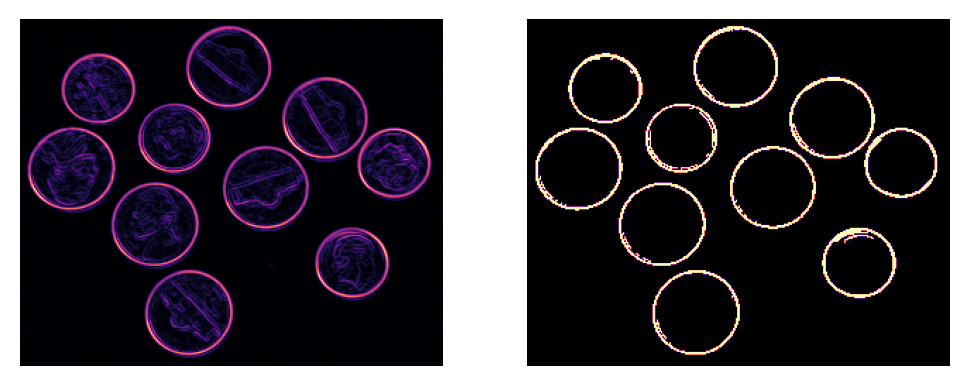

In [79]:
thresholded = fast_hysteresis_thresholding(img)
fig, ax = plt.subplots(1,2,dpi=200)
ax[0].imshow(img, cmap='magma')
ax[1].imshow(thresholded, cmap='magma')
for axis in ax: axis.set_axis_off()

## 3.4 Time Counter
Finally, we would like to compare the time it takes for the slow implementation and the fast implementation to run. To do so, we ask you to complete the time_counter function below.

_Note_: the desired function may take any function, its goal is just to compute mean and std of the execution time.

_Hint:_ You can use the imported module `time` and the function `time()`, in particular. It returns the time in seconds starting with 1970 year. Find a way how to apply it.

In [80]:
def time_counter(func, image, n):
    '''
    This function records the time taken for a function to run for a number of iterations. 
    To complete it, use the function time.time() to compute the difference between the time before executing
    the function and after executing it. Save the results on an array of size the number of iterations 
    to compute the mean and std in the end. 
    
    func:       A function to be tested for execution time (for input X one can compute func(X) ). 
    image:      The input image to the function func (e.g. fast_hysteresis_thresholding(image))
    iterations: Number of iterations.
    
    return
        mean:  The average of execution times taken across all the iterations. 
        std:   The standard deviation of execution times taken across all the iterations. 
        
    '''
    # Complete the function
    times = []
    for _ in range(n):
        start_time = time.time()
        func(image)
        end_time = time.time()
        times.append(end_time - start_time)
    return np.mean(times), np.std(times)

### SAVING MIGHT TAKE TIME :)
# Let us save the output of your function on some custom inputs 
save_student_results.save_time_counter(locals())

In [81]:
### here are some testing lines for you:
time_fast = time_counter(fast_hysteresis_thresholding, img, 10)
time_slow = time_counter(slow_hysteresis_thresholding, labeled_img, 1)

In [82]:
time_ratio = time_fast[0]/time_slow[0]*100
print(f'{time_ratio:.2f}%')

0.03%


You should get that the fast implementation takes less than 2% of the time of the slow implentation. 

### Hysteresis is done!